## Downloading the data set ##

In [ ]:
import requests
import zipfile
import io
import os
from tqdm import tqdm

# URL of the dataset to be downloaded
dataset_url = "https://archive.ics.uci.edu/static/public/773/defungi.zip"
output_dir = "defungi"  # Directory to extract the dataset

# Function to download and extract the dataset
def download_and_extract_dataset(url, extract_to):
    print("Starting dataset download...")
    
    # Send a GET request to fetch the dataset
    response = requests.get(url, stream=True)
    total_file_size = int(response.headers.get('content-length', 0))  # Total size of the file
    
    # Progress bar setup
    progress_bar = tqdm(total=total_file_size, unit='iB', unit_scale=True, desc="Downloading")
    
    # Temporary buffer to store the downloaded data
    with io.BytesIO() as temp_buffer:
        for chunk in response.iter_content(chunk_size=1024):  # Download in chunks of 1KB
            progress_bar.update(len(chunk))
            temp_buffer.write(chunk)
        progress_bar.close()

        if total_file_size != 0 and progress_bar.n != total_file_size:
            print("Warning: Downloaded file size does not match the expected size.")

        print("Download completed. Proceeding to extract files...")

        # Extract the dataset
        temp_buffer.seek(0)  # Move pointer to the beginning of the buffer
        with zipfile.ZipFile(temp_buffer) as zip_file:
            zip_file.extractall(extract_to)
        print(f"Extraction completed. Files are extracted to '{extract_to}'.")

# Call the function to download and extract the dataset
download_and_extract_dataset(dataset_url, output_dir)

# List and display the contents of the extracted directory
extracted_files = os.listdir(output_dir)
print("Extracted files:", extracted_files)


## Split the data set ##

In [13]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define the root dataset directory and category labels
data_root = "defungi"
class_labels = [
    "H6","H5","H3","H2","H1"
]

# Initialize lists to store file paths and corresponding labels
file_paths = []
numeric_labels = []

# Traverse each category directory to gather image paths and their labels
for idx, category_name in enumerate(class_labels):
    category_dir = os.path.join(data_root, category_name)
    
    # Ensure we only include valid files
    for file_name in os.listdir(category_dir):
        full_path = os.path.join(category_dir, file_name)
        if os.path.isfile(full_path):
            file_paths.append(full_path)
            numeric_labels.append(idx)  # Assign numeric label based on the category index

# Split dataset into training (60%), temporary (40%) for validation and testing
train_files, temp_files, train_labels, temp_labels = train_test_split(
    file_paths, numeric_labels, test_size=0.4, random_state=42
)

# Split the temporary dataset into validation (20%) and testing (20%)
val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels, test_size=0.5, random_state=42
)

# Define a function to organize and copy files into structured directories
def organize_files(file_list, label_list, split_name, base_dir="processed_dataset"):
    split_dir = os.path.join(base_dir, split_name)
    os.makedirs(split_dir, exist_ok=True)

    # Create subdirectories for each class in the dataset
    for label in class_labels:
        os.makedirs(os.path.join(split_dir, label), exist_ok=True)

    # Copy each file to its corresponding class folder
    for file_path, label in zip(file_list, label_list):
        category_name = class_labels[label]
        target_dir = os.path.join(split_dir, category_name)
        shutil.copy(file_path, target_dir)

# Organize the files into train, validation, and test splits
organize_files(train_files, train_labels, "train")
organize_files(val_files, val_labels, "val")
organize_files(test_files, test_labels, "test")

# Print dataset statistics
print("Dataset splitting completed:")
print(f"Training set: {len(train_files)} images")
print(f"Validation set: {len(val_files)} images")
print(f"Testing set: {len(test_files)} images")

# Optionally, delete the original dataset to save space
shutil.rmtree(data_root)
print("\nOriginal dataset directory removed.")


Dataset splitting completed:
Training set: 5468 images
Validation set: 1823 images
Testing set: 1823 images

Original dataset directory removed.


## Define the CNN ##

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Initialize the Sequential model
cnn_model = models.Sequential()

# Input layer: Specify the input shape (64x64 RGB images)
cnn_model.add(layers.Input(shape=(64, 64, 3)))  # Input shape (height, width, channels)

# First convolutional layer: Apply 64 filters with a 3x3 kernel and ReLU activation
cnn_model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))

# First max pooling layer: Reduce spatial dimensions using a 2x2 pooling window
cnn_model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Second convolutional layer: Apply 64 filters with a 3x3 kernel and ReLU activation
cnn_model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))

# Second max pooling layer: Further reduce spatial dimensions using a 2x2 pooling window
cnn_model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Third convolutional layer: Apply 16 filters with a 4x4 kernel and ReLU activation
cnn_model.add(layers.Conv2D(filters=16, kernel_size=(4, 4), activation='relu'))


# Flatten the output from the convolutional layers to feed into the dense layers
cnn_model.add(layers.Flatten())

# Fully connected (dense) layer: Apply 128 units with ReLU activation
cnn_model.add(layers.Dense(units=128, activation='relu'))

# Dropout layer: Reduce overfitting by randomly dropping 50% of the units during training
cnn_model.add(layers.Dropout(rate=0.5))

# Output layer: Use 9 units (for 9 classes) with softmax activation for classification
cnn_model.add(layers.Dense(units=9, activation='softmax'))

# Compile the model: Use Adam optimizer, sparse categorical crossentropy loss, and track accuracy
cnn_model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

# Display the model architecture
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 16)        16400     
                                                                 
 flatten (Flatten)           (None, 1936)              0

## Train the model ##

Found 5468 images belonging to 5 classes.
Found 1823 images belonging to 5 classes.
Epoch 1/20
171/171 [==============================] - 17s 94ms/step - loss: 1.2734 - accuracy: 0.5181 - val_loss: 1.1717 - val_accuracy: 0.5310
Epoch 2/20
171/171 [==============================] - 14s 85ms/step - loss: 1.1106 - accuracy: 0.5593 - val_loss: 1.1936 - val_accuracy: 0.4674
Epoch 3/20
171/171 [==============================] - 14s 79ms/step - loss: 1.0604 - accuracy: 0.5741 - val_loss: 1.0850 - val_accuracy: 0.5798
Epoch 4/20
171/171 [==============================] - 13s 75ms/step - loss: 1.0579 - accuracy: 0.5808 - val_loss: 1.0203 - val_accuracy: 0.5946
Epoch 5/20
171/171 [==============================] - 14s 80ms/step - loss: 0.9908 - accuracy: 0.6022 - val_loss: 0.9667 - val_accuracy: 0.5990
Epoch 6/20
171/171 [==============================] - 14s 79ms/step - loss: 0.9767 - accuracy: 0.6134 - val_loss: 1.0364 - val_accuracy: 0.6012
Epoch 7/20
171/171 [==============================] 

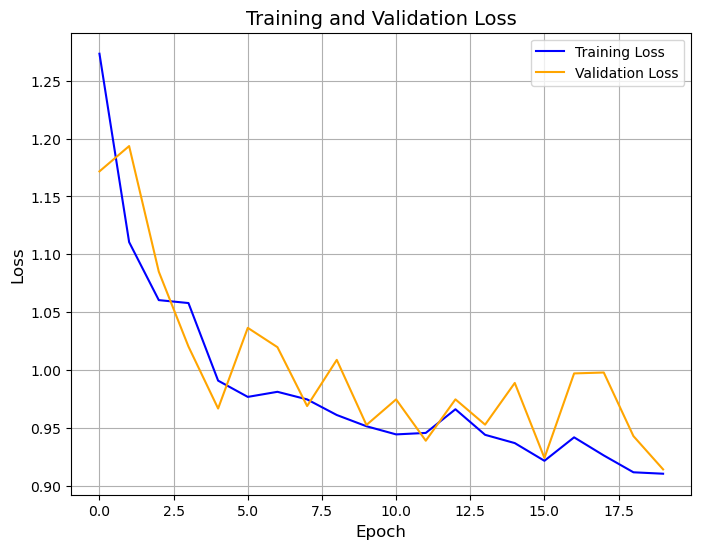

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Initialize data generators for training and validation datasets
# Rescale pixel values to the range [0, 1] by dividing by 255
train_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)
validation_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)

# Define the training data generator
training_generator = train_data_generator.flow_from_directory(
    'processed_dataset/train',  # Path to training data
    target_size=(64, 64),       # Resize all images to 64x64 pixels
    batch_size=32,              # Number of images per batch
    class_mode='sparse'         # Sparse labels for multi-class classification
)

# Define the validation data generator
validation_generator = validation_data_generator.flow_from_directory(
    'processed_dataset/val',    # Path to validation data
    target_size=(64, 64),       # Resize all images to 64x64 pixels
    batch_size=32,              # Number of images per batch
    class_mode='sparse'         # Sparse labels for multi-class classification
)

# Train the model and record training history
model_history = cnn_model.fit(
    training_generator,         # Training data generator
    epochs=20,                  # Number of epochs for training
    validation_data=validation_generator  # Validation data generator
)

# Plot training and validation loss over epochs
plt.figure(figsize=(8, 6))  # Set figure size
plt.plot(model_history.history['loss'], label='Training Loss', color='blue')  # Training loss
plt.plot(model_history.history['val_loss'], label='Validation Loss', color='orange')  # Validation loss
plt.xlabel('Epoch', fontsize=12)  # Label for x-axis
plt.ylabel('Loss', fontsize=12)   # Label for y-axis
plt.title('Training and Validation Loss', fontsize=14)  # Plot title
plt.legend(fontsize=10)          # Add legend
plt.grid(True)                   # Add gridlines for better readability
plt.show()


Found 5468 images belonging to 5 classes.
170/170 [==============================] - 8s 49ms/step - loss: 2.1659 - accuracy: 0.2605
Test Accuracy: 26.05%
Test Loss: 2.1659
171/171 [==============================] - 9s 50ms/step


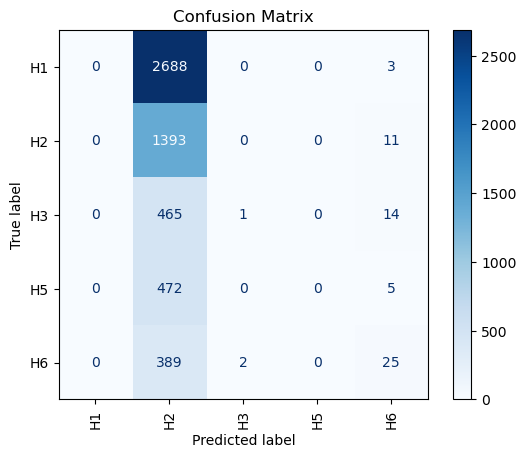


Precision for each class:
H1: 0.0000
H2: 0.2576
H3: 0.3333
H5: 0.0000
H6: 0.4310

Recall for each class:
H1: 0.0000
H2: 0.9922
H3: 0.0021
H5: 0.0000
H6: 0.0601


C:\Users\kdwa2\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up ImageDataGenerator for the testing data
test_datagen = ImageDataGenerator(rescale=1./255)

# Set up the directory for the testing data
test_dir = 'processed_dataset/test'

# Create a test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),  # Resize images to 64x64
    batch_size=32,
    class_mode='sparse',  # Use sparse labels for integer labels
    shuffle=False  # Don't shuffle so we can map the predictions to the true labels
)

# Evaluate the model on the testing data
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Get the true labels and predictions
true_labels = test_generator.classes
predictions = model.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size).astype(int))

# Convert predictions from probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.xticks(rotation=90)  # Rotate x-axis labels vertically
plt.title('Confusion Matrix')
plt.show()

# Precision and Recall for each class
precision = precision_score(true_labels, predicted_labels, average=None)
recall = recall_score(true_labels, predicted_labels, average=None)

print("\nPrecision for each class:")
for i, class_name in enumerate(test_generator.class_indices.keys()):
    print(f"{class_name}: {precision[i]:.4f}")

print("\nRecall for each class:")
for i, class_name in enumerate(test_generator.class_indices.keys()):
    print(f"{class_name}: {recall[i]:.4f}")


## Plot training and validation loss for different learning rates such as 0.0001, 0.001, 0.01, and 0.1

Epoch 1/20
171/171 [==============================] - 14s 80ms/step - loss: 1.3971 - accuracy: 0.4835 - val_loss: 1.1820 - val_accuracy: 0.5387
Epoch 2/20
171/171 [==============================] - 13s 77ms/step - loss: 1.1811 - accuracy: 0.5422 - val_loss: 1.1031 - val_accuracy: 0.5650
Epoch 3/20
171/171 [==============================] - 13s 77ms/step - loss: 1.1236 - accuracy: 0.5596 - val_loss: 1.0637 - val_accuracy: 0.5869
Epoch 4/20
171/171 [==============================] - 13s 77ms/step - loss: 1.0742 - accuracy: 0.5733 - val_loss: 1.0227 - val_accuracy: 0.6072
Epoch 5/20
171/171 [==============================] - 13s 77ms/step - loss: 1.0524 - accuracy: 0.5922 - val_loss: 1.0122 - val_accuracy: 0.6061
Epoch 6/20
171/171 [==============================] - 13s 76ms/step - loss: 1.0311 - accuracy: 0.5918 - val_loss: 0.9997 - val_accuracy: 0.5946
Epoch 7/20
171/171 [==============================] - 13s 78ms/step - loss: 1.0196 - accuracy: 0.5920 - val_loss: 0.9906 - val_accuracy:

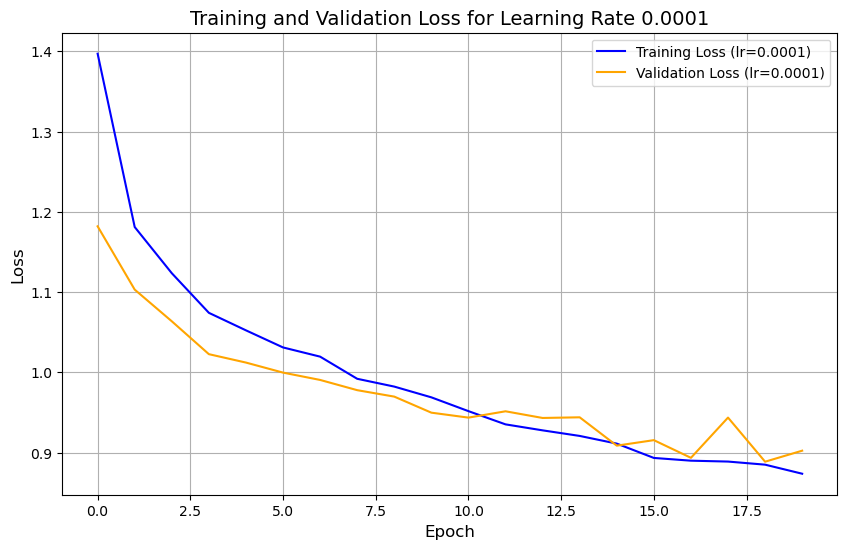

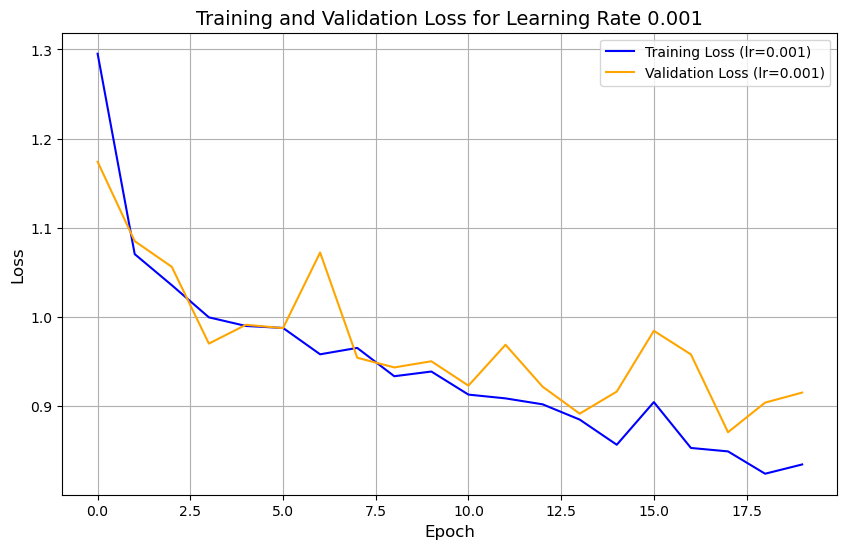

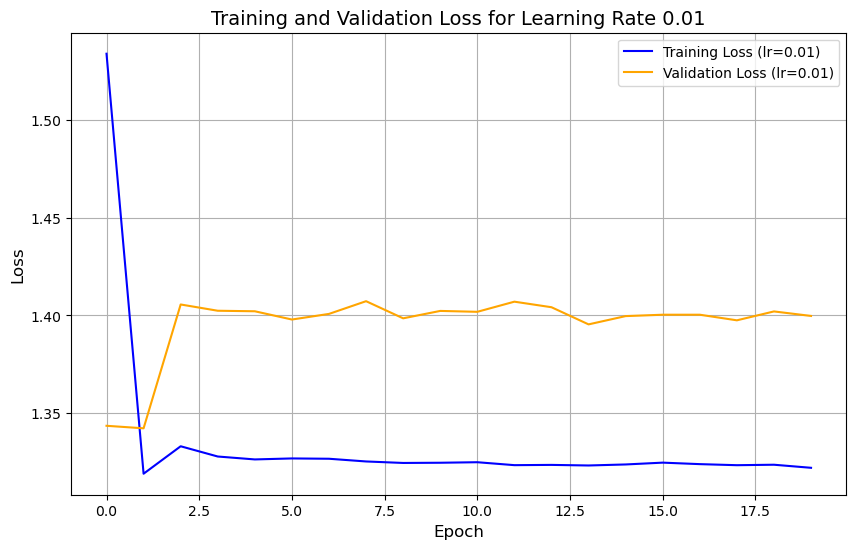

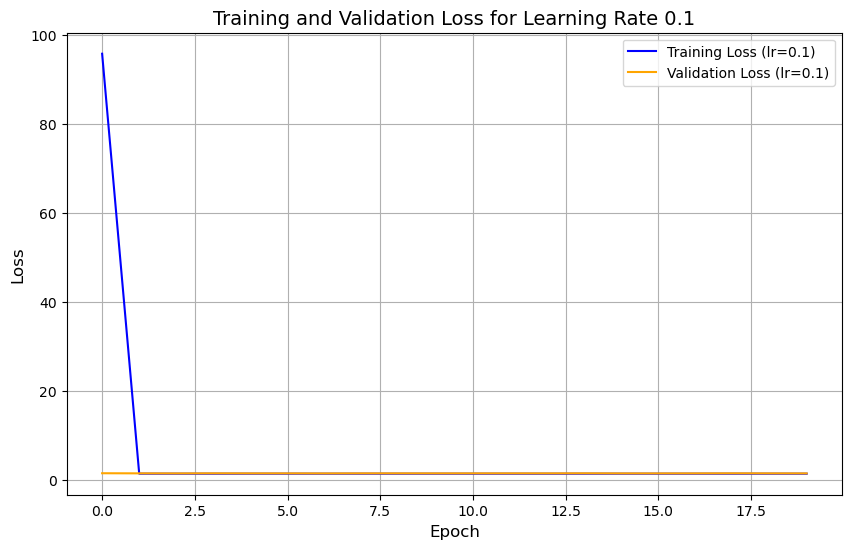

In [4]:
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Define a list of learning rates to experiment with
learning_rate_options = [0.0001, 0.001, 0.01, 0.1]
training_histories = []  # To store training histories for each learning rate

# Loop through each learning rate
for learning_rate in learning_rate_options:
    # Build the CNN model
    cnn_model_experiment = models.Sequential()
    cnn_model_experiment.add(layers.Input(shape=(64, 64, 3)))  # Input layer for images of size 64x64x3
    cnn_model_experiment.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))  # Conv layer with 32 filters
    cnn_model_experiment.add(layers.MaxPooling2D(pool_size=(2, 2)))  # MaxPooling layer
    cnn_model_experiment.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))  # Conv layer with 64 filters
    cnn_model_experiment.add(layers.MaxPooling2D(pool_size=(2, 2)))  # MaxPooling layer
    cnn_model_experiment.add(layers.Flatten())  # Flatten output for dense layers
    cnn_model_experiment.add(layers.Dense(units=128, activation='relu'))  # Fully connected layer with 128 units
    cnn_model_experiment.add(layers.Dropout(0.5))  # Dropout layer to reduce overfitting
    cnn_model_experiment.add(layers.Dense(units=9, activation='softmax'))  # Output layer for 9 classes

    # Compile the model using the current learning rate
    cnn_model_experiment.compile(
        optimizer=Adam(learning_rate=learning_rate),  # Adam optimizer with specified learning rate
        loss='sparse_categorical_crossentropy',       # Loss function for multi-class classification
        metrics=['accuracy']                         # Evaluate using accuracy
    )

    # Train the model and save the training history
    history = cnn_model_experiment.fit(
        training_generator,      # Training data generator
        epochs=20,               # Train for 20 epochs
        validation_data=validation_generator,  # Validation data generator
        verbose=1                # Display training progress
    )

    # Append the training history for later analysis
    training_histories.append(history)

# Plot the training and validation loss for each learning rate
for index, learning_rate in enumerate(learning_rate_options):
    plt.figure(figsize=(10, 6))  # Set figure size
    plt.plot(
        training_histories[index].history['loss'], 
        label=f'Training Loss (lr={learning_rate})', color='blue'
    )  # Plot training loss
    plt.plot(
        training_histories[index].history['val_loss'], 
        label=f'Validation Loss (lr={learning_rate})', color='orange'
    )  # Plot validation loss
    plt.xlabel('Epoch', fontsize=12)  # Label for x-axis
    plt.ylabel('Loss', fontsize=12)   # Label for y-axis
    plt.legend(fontsize=10)           # Add legend for clarity
    plt.title(f'Training and Validation Loss for Learning Rate {learning_rate}', fontsize=14)  # Plot title
    plt.grid(True)                    # Add gridlines
    plt.show()


## Resnet and VGG16 models


Found 5468 images belonging to 5 classes.
Found 1823 images belonging to 5 classes.
Found 1823 images belonging to 5 classes.


58889256/58889256 [==============================] - 18s 0us/step

Training ResNet50...

Epoch 1/10


171/171 [==============================] - 190s 867ms/step - loss: 1.2036 - accuracy: 0.5911 - val_loss: 2.1980 - val_accuracy: 0.4536
Epoch 2/10
171/171 [==============================] - 140s 817ms/step - loss: 0.8773 - accuracy: 0.6498 - val_loss: 74.4275 - val_accuracy: 0.4536
Epoch 3/10
171/171 [==============================] - 138s 807ms/step - loss: 0.8309 - accuracy: 0.6726 - val_loss: 73.2426 - val_accuracy: 0.4536
Epoch 4/10
171/171 [==============================] - 139s 815ms/step - loss: 0.8219 - accuracy: 0.6748 - val_loss: 2.5266 - val_accuracy: 0.4536
Epoch 5/10
171/171 [==============================] - 142s 828ms/step - loss: 0.7719 - accuracy: 0.6928 - val_loss: 18.1308 - val_accuracy: 0.4750
Epoch 6/10
171/171 [===========================

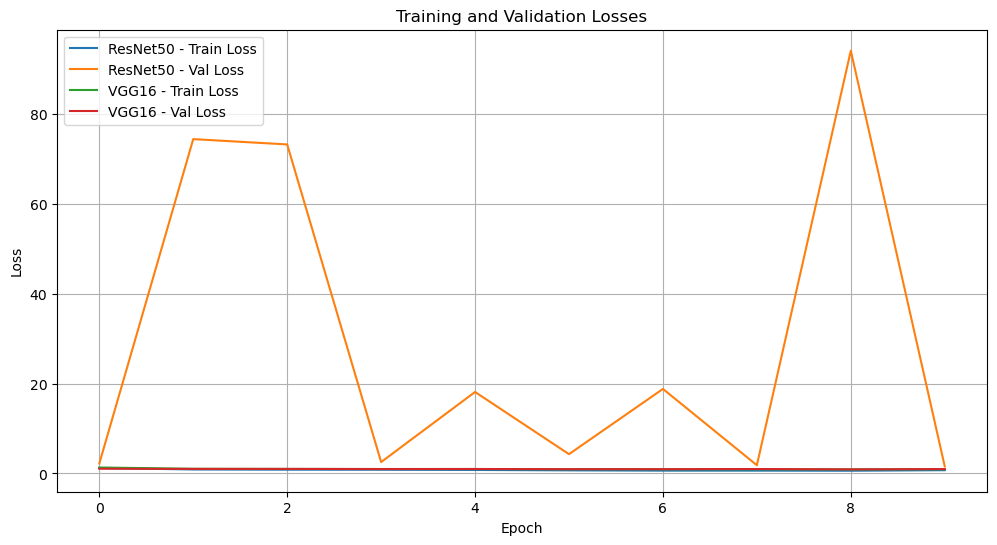

C:\Users\kdwa2\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


ResNet50 saved successfully.
VGG16 saved successfully.


In [1]:
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Paths for dataset splits
train_dir = 'processed_dataset/train'
val_dir = 'processed_dataset/val'
test_dir = 'processed_dataset/test'

# Data Generators
data_gen = ImageDataGenerator(rescale=1./255)

train_gen = data_gen.flow_from_directory(train_dir, target_size=(64, 64), batch_size=32, class_mode='categorical')
val_gen = data_gen.flow_from_directory(val_dir, target_size=(64, 64), batch_size=32, class_mode='categorical')
test_gen = data_gen.flow_from_directory(test_dir, target_size=(64, 64), batch_size=32, class_mode='categorical', shuffle=False)

# Number of classes
num_classes = len(train_gen.class_indices)

# Pre-trained models
models_to_train = {
    "ResNet50": ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3)),
    "VGG16": VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
}

# Adding custom classification heads
for model_name, base_model in models_to_train.items():
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)
    models_to_train[model_name] = Model(inputs=base_model.input, outputs=output)

# Compile models
for model_name, model in models_to_train.items():
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train models
results = {}
for model_name, model in models_to_train.items():
    print(f"\nTraining {model_name}...\n")
    history = model.fit(train_gen, validation_data=val_gen, epochs=10)
    results[model_name] = history

# Evaluate models on the test set
for model_name, model in models_to_train.items():
    test_loss, test_acc = model.evaluate(test_gen)
    print(f"{model_name} Test Accuracy: {test_acc:.2f}%")

# Plot training and validation losses
plt.figure(figsize=(12, 6))
for model_name, history in results.items():
    plt.plot(history.history['loss'], label=f"{model_name} - Train Loss")
    plt.plot(history.history['val_loss'], label=f"{model_name} - Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Losses")
plt.legend()
plt.grid()
plt.show()

# Save the models
for model_name, model in models_to_train.items():
    model.save(f"{model_name}_model.h5")
    print(f"{model_name} saved successfully.")